In [1]:
!pip install wfdb
import numpy as np
import pandas as pd
import wfdb
import os
import shutil
import glob
import re
import matplotlib.pyplot as plt
from wfdb import rdrecord, rdann, processing
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate

     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 163kB 9.4MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=d22e225374db49ea9dd44cd5926e7de71909ebbbb5929375d494fec2325cff95
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb


Using TensorFlow backend.


# 1. Read the datasets from the database
* MIT-BIH Arrhythmia Database has a collection of 48 fully annotated half-hour two-lead ECGs.
* the database link: https://physionet.org/content/mitdb/1.0.0/
* convert the download the related files: https://archive.physionet.org/cgi-bin/atm/ATM
* another online tool to view the data: https://physionet.org/lightwave/

In [4]:
def read_file_names(path):
    """Extract the names of the datasets."""
    files = glob.glob(path + '*.dat')
    nums = []
    for file in files:
        file_name = os.path.basename(file)
        file_name = re.sub('.dat', '', file_name)
        nums.append(file_name)
    return nums

#Read the names of both normal and abnormal(chf) datasets.
path = './dataset/mit-bih-arrhythmia/'
nums = read_file_names(path)
print(nums)

['230', '100', '118', '114', '104', '212', '117', '222', '221', '119', '116', '115', '208', '234', '105', '232', '124', '233', '107', '210', '103', '217', '205', '113', '121', '214', '231', '109', '200', '223', '201', '101', '202', '123', '220', '228', '108', '219', '102', '106', '207', '213', '112', '111', '209', '203', '122', '215']


# 2. Read the ECG signal and annotation for each dataset
* separate the heartbeat of each dataset
* read the corresponding annotation for all the heartbeats.
* generate the csv file, each row is the record for one heartbeat including the ecg and annotation number code.
* the heartbeat classes: 'N', 'V', '/', 'A', 'F'

In [5]:
def heartbeat_segmentation(path, nums):
    """separate the heartbeats for all the datasets"""
    signals = [] 
    anns = []
    hb_count = 0
    hb_len_count = 0
    hb_final_count = 0
    for num in nums:
        print("This is dataset %s being processed..." % num)
        #Read the dataset, pick up the ecg signal channel and the length
        record = rdrecord(path + num, sampfrom=0, sampto=50000, channels=[0])

        #Detecting the qrs complexs in the dataset
        qrs_inds = processing.gqrs_detect(sig=record.p_signal[:, 0], fs=record.fs)
  
        #Correct the peaks and shift them to local maxima
        min_bpm = 20
        max_bpm = 230

        #Use the maximum possible bpm as the search radius
        search_radius = int(record.fs * 60 / max_bpm)
        peak_inds = processing.correct_peaks(record.p_signal[:,0], peak_inds=qrs_inds,
                                                       search_radius=search_radius, smooth_window_size=150)
        #print("The R peaks have been obtained..." )
        
        #Segment the heartbeats in the dataset
        sig = record.p_signal[:, 0]

        count = 1
        count_len_limit = 1
        count_final = 1
        for peak in peak_inds[1:-1]:
            diff1 = abs(peak_inds[count - 1] - peak)
            diff2 = abs(peak_inds[count + 1] - peak)
            start = peak_inds[count - 1] + diff1 // 2
            end =  peak_inds[count + 1] - diff2 // 2
            signal = sig[start: end]
            count += 1
            
            #Normalize the signal
            signal = signal - np.mean(signal)
            #Pick up the heartbeat segments and save it for further use. 
            if len(signal) < 400:
                #Read the corresponding annotation for each heartbeat
                ann = rdann(path + num, extension='atr', sampfrom = start, sampto = end, return_label_elements=['symbol'])
                ann_symbol = ann.symbol
                count_len_limit += 1
                if len(ann_symbol) == 1:
                    signal = np.concatenate([signal, np.zeros(400-len(signal))])
                    signals.append(signal)
                    anns.append(ann_symbol[0])
                    count_final += 1
        #print("The ecg + annnotation segments have been obtained..." )
        #print("the heartbeats number in total is %d" % count)
        hb_count += count
        hb_len_count += count_len_limit
        hb_final_count += count_final
        #print(count, count_len_limit, count_final)
    return signals, anns

def anns_to_num(annotation):
    """transform the annotations to num code"""
    for i in range(len(annotation)):
        if annotation[i] == 'N': #normal beats
            annotation[i] = 0
        elif annotation[i] == 'V': #premature ventricular beat
            annotation[i] = 1
        elif annotation[i] == '/': #paced beat
            annotation[i] = 2
        elif annotation[i] == 'A': #premature atrial beat
            annotation[i] = 3
        elif annotation[i] == 'F': #fusion of ventricular and normal beat
            annotation[i] = 4
        else:
            annotation[i] = 5
    return annotation

#save the segements of normal datasets to csv file
signals, annotation = heartbeat_segmentation(path, nums)
anns = anns_to_num(annotation)

signals_csv = np.matrix(signals)
anns_csv = np.matrix(anns)
print(signals_csv.shape, anns_csv.shape)

comb_sig_ann = np.concatenate((signals_csv, anns_csv.T), axis=1)
df = pd.DataFrame(comb_sig_ann)
df.to_csv('arrythmias.csv', index=False)

This is dataset 230 being processed...
This is dataset 100 being processed...
This is dataset 118 being processed...
This is dataset 114 being processed...
This is dataset 104 being processed...
This is dataset 212 being processed...
This is dataset 117 being processed...
This is dataset 222 being processed...
This is dataset 221 being processed...
This is dataset 119 being processed...
This is dataset 116 being processed...
This is dataset 115 being processed...
This is dataset 208 being processed...
This is dataset 234 being processed...
This is dataset 105 being processed...
This is dataset 232 being processed...
This is dataset 124 being processed...
This is dataset 233 being processed...
This is dataset 107 being processed...
This is dataset 210 being processed...
This is dataset 103 being processed...
This is dataset 217 being processed...
This is dataset 205 being processed...
This is dataset 113 being processed...
This is dataset 121 being processed...
This is dataset 214 being

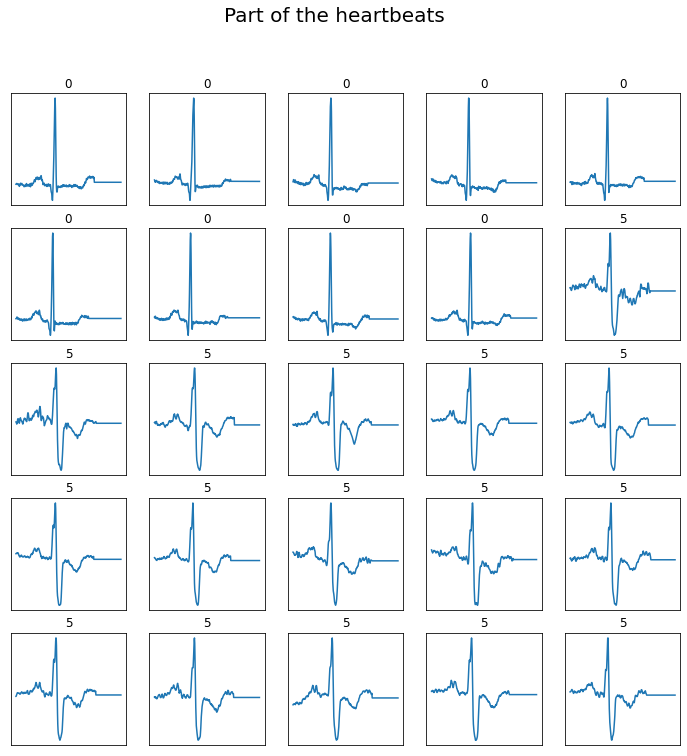

In [6]:
def plot_segments(signals, title):
    """visualize the heartbeats extracted above"""
    plt.figure(figsize=(12, 12))
    col_num = 5
    row_num = 5
    signal_nums = 25
    k = 13
    for i in range(signal_nums):
        plt.subplot(row_num, col_num, i+1)
        plt.plot(signals[i + k*signal_nums]) # pay attention to the range
        plt.title(anns[i + k*signal_nums])
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(title, size=20) 
    plt.show()

#check part of the hearbeats
plot_segments(signals, 'Part of the heartbeats')

In [7]:
#check the annotation data before next move
print(set(anns))
for ann in set(anns):
    print (ann, anns.count(ann))

{0, 1, 2, 3, 4, 5}
0 5439
1 476
2 512
3 89
4 48
5 1034


In [0]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("./arrythmias.csv", skiprows=[0], header=None)
X = np.array(df[list(range(400))].values)[..., np.newaxis]
y = np.array(df[400].values).astype(np.int8)
#separate the datasets into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
def get_model():
    nclass = 6
    inp = Input(shape=(400, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_patterns")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

model = get_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 16)           96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 392, 16)           1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 196, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 194, 32)           1568      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 192, 32)           3104

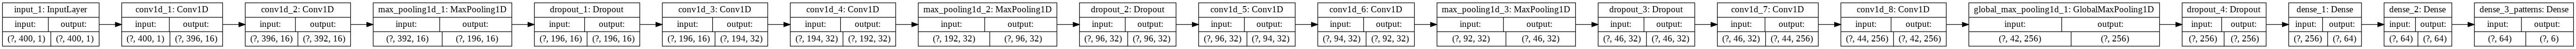

In [11]:
from tensorflow.keras.utils import plot_model
# plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR')

In [13]:
file_path = "arrythmias_classification.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat] 

model.fit(X_train, y_train, epochs=100, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(y_test, pred_test, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, pred_test)
print("Test accuracy score : %s "% acc)

Train on 4786 samples, validate on 532 samples
Epoch 1/100
 - 13s - loss: 0.7927 - acc: 0.7503 - val_loss: 0.4486 - val_acc: 0.8778

Epoch 00001: val_acc improved from -inf to 0.87782, saving model to arrythmias_classification.h5
Epoch 2/100
 - 12s - loss: 0.3706 - acc: 0.8838 - val_loss: 0.2386 - val_acc: 0.9323

Epoch 00002: val_acc improved from 0.87782 to 0.93233, saving model to arrythmias_classification.h5
Epoch 3/100
 - 12s - loss: 0.2541 - acc: 0.9327 - val_loss: 0.1812 - val_acc: 0.9492

Epoch 00003: val_acc improved from 0.93233 to 0.94925, saving model to arrythmias_classification.h5
Epoch 4/100
 - 13s - loss: 0.2118 - acc: 0.9405 - val_loss: 0.2183 - val_acc: 0.9455

Epoch 00004: val_acc did not improve from 0.94925
Epoch 5/100
 - 12s - loss: 0.1983 - acc: 0.9446 - val_loss: 0.2034 - val_acc: 0.9455

Epoch 00005: val_acc did not improve from 0.94925
Epoch 6/100
 - 12s - loss: 0.1543 - acc: 0.9601 - val_loss: 0.1320 - val_acc: 0.9680

Epoch 00006: val_acc improved from 0.949